# COURSE:   PGP [AI&ML]

## Learner :  Chaitanya Kumar Battula
## Module  : Deep Learning
## Topic   : DigitReader_Hyper Parameter Training

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#set figure size
plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('white')

# others
from random import randrange
from time import time

In [2]:
n_epochs = 30 # 30 
n_epochs_cv = 10 # 10  # reduce number of epochs for cross validation for performance reason

n_cv = 3
validation_ratio = 0.10

In [3]:
# load dataset and check dimension
data_set = pd.read_csv('digit-recognizer-train.csv')
print(data_set.shape)

(42000, 785)


In [4]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
#del data_set

# check distribution of the handwritten digits
#sns.countplot(y, color='skyblue');

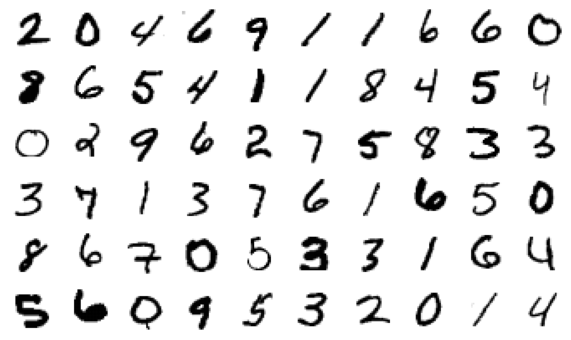

In [11]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(6, 10, figsize=(10, 6)) # 6 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [5]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

# extract train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = validation_ratio)

2. Implementing a simple MLP
Let's start with a simple multilayer perceptron with only 1 hidden layer:

the input layer consists in 128 units, with relu
the hidden layer is made of 64 units, with sigmoid activation function
the output layer contains one unit per expected class, that is 10 units, and uses a softmax activation function to output probabilities
How many parameters has this model?
the input layer is taking values from 28x28 images: the number of parameters is 28x28 (input size) x 128 (output size) weights + 128 bias values = 100,480
for the hidden layer, a similar caculation gives 128 x 64 + 64 = 8,256
and for the output layer, we have 64 x 10 + 10 = 650 parameters
OK, this was easy, but we'll see below that counting parameters of CNN is a bit more tricky.

In [6]:
# define model
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Train the model

#define callbacks
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train,
    to_categorical(y_train),
    epochs = n_epochs,  
    validation_data = (X_val, to_categorical(y_val)),
    batch_size = 32,
    callbacks = [early_stop]
)

Epoch 1/30
1182/1182 [==============================] - 4s 2ms/step - loss: 0.7261 - accuracy: 0.8138 - val_loss: 0.1994 - val_accuracy: 0.9426
Epoch 2/30
1182/1182 [==============================] - 1s 988us/step - loss: 0.1629 - accuracy: 0.9518 - val_loss: 0.1398 - val_accuracy: 0.9562
Epoch 3/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.1009 - accuracy: 0.9693 - val_loss: 0.1143 - val_accuracy: 0.9660
Epoch 4/30
1182/1182 [==============================] - 1s 977us/step - loss: 0.0726 - accuracy: 0.9785 - val_loss: 0.1053 - val_accuracy: 0.9683
Epoch 5/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0529 - accuracy: 0.9853 - val_loss: 0.1028 - val_accuracy: 0.9686
Epoch 6/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.0893 - val_accuracy: 0.9740
Epoch 7/30
1182/1182 [==============================] - 1s 1ms/step - loss: 0.0280 - accuracy: 0.9922 - val_loss: 0.0947 - val_accur

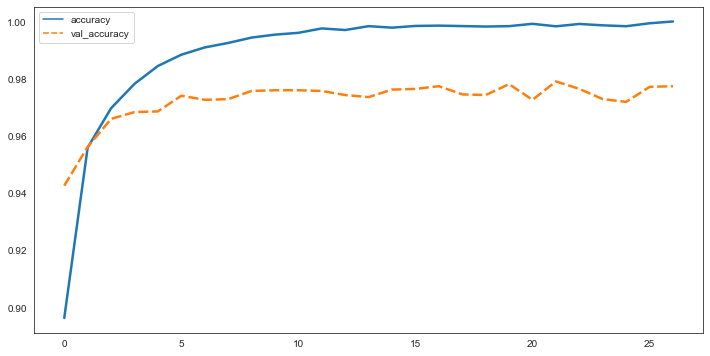

In [8]:
# compare accuracy accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

# 3. Optimize hyperparameters and add dropout to reduce overfit

In [9]:
start=time()

# define a function to create model, required for KerasClassifier
# the function takes drop_out rate as argument so we can optimize it  
def create_mlp_model(dropout_rate=0):
    # create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,))) 
    # add a dropout layer if rate is not null
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))        
    model.add(Dense(64, activation='sigmoid')) 
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))           
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))    
    
# create model
model = KerasClassifier(build_fn=create_mlp_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [n_epochs_cv],
    'dropout_rate': [0.0, 0.10, 0.20, 0.30],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=n_cv)
grid_result = grid.fit(X, to_categorical(y))  # fit the full dataset as we are using cross validation 

# print out results
print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

Epoch 1/10
2625/2625 [==============================] - 5s 841us/step - loss: 0.6899 - accuracy: 0.7989
Epoch 2/10
2625/2625 [==============================] - 2s 783us/step - loss: 0.1902 - accuracy: 0.9435
Epoch 3/10
2625/2625 [==============================] - 2s 785us/step - loss: 0.1311 - accuracy: 0.9607
Epoch 4/10
2625/2625 [==============================] - 2s 785us/step - loss: 0.1093 - accuracy: 0.9663
Epoch 5/10
2625/2625 [==============================] - 2s 775us/step - loss: 0.0897 - accuracy: 0.9728
Epoch 6/10
2625/2625 [==============================] - 2s 818us/step - loss: 0.0775 - accuracy: 0.9756
Epoch 7/10
2625/2625 [==============================] - 2s 790us/step - loss: 0.0715 - accuracy: 0.9772
Epoch 8/10
2625/2625 [==============================] - 2s 850us/step - loss: 0.0634 - accuracy: 0.9805
Epoch 9/10
2625/2625 [==============================] - 2s 787us/step - loss: 0.0589 - accuracy: 0.9803
Epoch 10/10
2625/2625 [==============================] - 2s 777u

In [10]:
# reload best model
mlp = grid_result.best_estimator_ 

# retrain best model on the full training set 
history = mlp.fit(
    X_train,
    to_categorical(y_train),
    validation_data = (X_val, to_categorical(y_val)),
    epochs = n_epochs,
    callbacks = [early_stop]    
)

Epoch 1/30
2363/2363 [==============================] - 4s 2ms/step - loss: 0.7150 - accuracy: 0.7985 - val_loss: 0.1775 - val_accuracy: 0.9467
Epoch 2/30
2363/2363 [==============================] - 3s 1ms/step - loss: 0.1943 - accuracy: 0.9425 - val_loss: 0.1299 - val_accuracy: 0.9612
Epoch 3/30
2363/2363 [==============================] - 3s 1ms/step - loss: 0.1343 - accuracy: 0.9604 - val_loss: 0.1122 - val_accuracy: 0.9667
Epoch 4/30
2363/2363 [==============================] - 2s 1ms/step - loss: 0.1107 - accuracy: 0.9672 - val_loss: 0.1041 - val_accuracy: 0.9671
Epoch 5/30
2363/2363 [==============================] - 3s 1ms/step - loss: 0.0934 - accuracy: 0.9712 - val_loss: 0.0971 - val_accuracy: 0.9695
Epoch 6/30
2363/2363 [==============================] - 3s 1ms/step - loss: 0.0813 - accuracy: 0.9761 - val_loss: 0.0888 - val_accuracy: 0.9736
Epoch 7/30
2363/2363 [==============================] - 3s 1ms/step - loss: 0.0710 - accuracy: 0.9773 - val_loss: 0.0947 - val_accuracy:

C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


263/263 [==============================] - 2s 477us/step
Accuracy on validation data = 0.9776


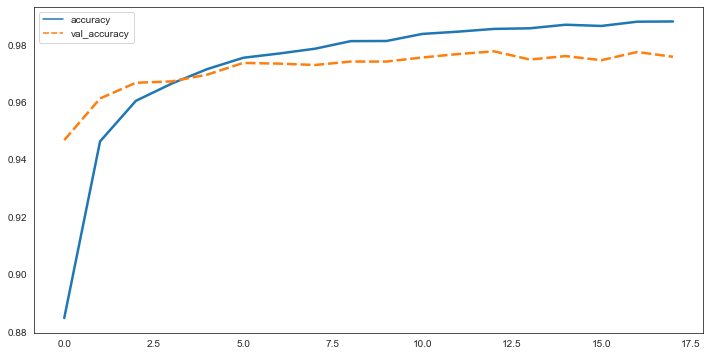

In [11]:
# get prediction on validation dataset 
y_pred = mlp.predict(X_val)
print('Accuracy on validation data = {:.4f}'.format(accuracy_score(y_val, y_pred)))

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [ ]:
# convert prediction to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)